# Homework 2: Classification

## Task 1: Classification on the ‘credit-g’ dataset

You can download the dataset with ‘fetch_openml(‘credit_g’)’ and see it’s description at
https://www.openml.org/d/31
    
1.1 Determine which features are continuous and which are categorical.

1.2 Visualize the univariate distribution of each continuous feature, and the distribution of the
target.

1.3 Split data into training and test set. Do not use the test set until a final evaluation in 1.5.
Preprocess the data (such as treatment of categorical variables) without using a pipeline and
evaluate an initial LogisticRegression model with an training/validation split.

1.4 Use ColumnTransformer and pipeline to encode categorical variables (your choice of
OneHotEncoder or another one from the categorical_encoder package, or both). Evaluate
Logistic Regression, linear support vector machines and nearest neighbors using
cross-validation. How different are the results? How does scaling the continuous features with
StandardScaler influence the results?

1.5 Tune the parameters using GridSearchCV. Do the results improve? Evaluate only the be
model on the test set.
Visualize the performance as function of the parameters for all three models.

1.6 Change the cross-validation strategy from ‘stratified k-fold’ to ‘kfold’ with shuffling. Do the
parameters that are found change? Do they change if you change the random seed of the
shuffling? Or if you change the random state of the split into training and test data?

1.7 Visualize the 20 most important coefficients for LogisticRegression and Linear Support
Vector Machines using hyper-parameters that performed well in the grid-search.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = fetch_openml("credit-g", version = "active")

Let's explore the data:

In [4]:
data

{'data': array([[ 0.,  6.,  4., ...,  1.,  1.,  0.],
        [ 1., 48.,  2., ...,  1.,  0.,  0.],
        [ 3., 12.,  4., ...,  2.,  0.,  0.],
        ...,
        [ 3., 12.,  2., ...,  1.,  0.,  0.],
        [ 0., 45.,  2., ...,  1.,  1.,  0.],
        [ 1., 45.,  4., ...,  1.,  0.,  0.]]),
 'target': array(['good', 'bad', 'good', 'good', 'bad', 'good', 'good', 'good',
        'good', 'bad', 'bad', 'bad', 'good', 'bad', 'good', 'bad', 'good',
        'good', 'bad', 'good', 'good', 'good', 'good', 'good', 'good',
        'good', 'good', 'good', 'good', 'bad', 'good', 'good', 'good',
        'good', 'good', 'bad', 'good', 'bad', 'good', 'good', 'good',
        'good', 'good', 'good', 'bad', 'good', 'good', 'good', 'good',
        'good', 'good', 'good', 'good', 'good', 'bad', 'good', 'bad',
        'good', 'good', 'bad', 'good', 'good', 'bad', 'bad', 'good',
        'good', 'good', 'good', 'bad', 'good', 'good', 'good', 'good',
        'good', 'bad', 'good', 'bad', 'good', 'good', 'good

Let's understand some of the data set features:

In [5]:
features = data['feature_names']

print("Dataset keys: {}".format(data.keys()))
print(" ")
print("Feature names: {}".format(features))

Dataset keys: dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])
 
Feature names: ['checking_status', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_status', 'employment', 'installment_commitment', 'personal_status', 'other_parties', 'residence_since', 'property_magnitude', 'age', 'other_payment_plans', 'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone', 'foreign_worker']


Will need to parse the data set into a pandas DataFrame, as well as assigning the correct data types, as the default for all features are objects.

In [6]:
# old function for converting to DataFrame
# def sklearn_to_df(sklearn_dataset):
#     df = pd.DataFrame(sklearn_dataset.data, columns=sklearn_dataset.feature_names)
#     df['target'] = pd.Series(sklearn_dataset.target)
#     return df

In [7]:
def sklearn_to_df():
    
    dataset = fetch_openml('credit-g', version = 'active')

    raws = [
        np.take(dataset['categories'][feature], dataset['data'][:,i].astype(int))  # Take string value for categorical features
        if feature in dataset['categories'] else dataset['data'][:,i]  # Else use the floats as is
        for i, feature in enumerate(dataset['feature_names'])
    ]

    data = pd.DataFrame(np.stack(raws, axis=1), columns=dataset.feature_names)
    data['class'] = pd.Series(dataset.target)
    print("Initial dtypes:")
    print(data.dtypes)

    dtypes = {
        f: 'category' if f in dataset['categories'] else 'float'
        for f in dataset['feature_names']
    }
    dtypes['class'] = 'category'
    data = data.astype(dtypes)
    print("\nFirst cast:")
    print(data.dtypes)

    int_cols = [1, 4, 12] # duration, credit_amount, age
    data.iloc[:, int_cols] = data.iloc[:, int_cols].astype('int64')
    print("\nInt cast:")
    print(data.dtypes)
    
    return data

In [8]:
df = sklearn_to_df()

Initial dtypes:
checking_status           object
duration                  object
credit_history            object
purpose                   object
credit_amount             object
savings_status            object
employment                object
installment_commitment    object
personal_status           object
other_parties             object
residence_since           object
property_magnitude        object
age                       object
other_payment_plans       object
housing                   object
existing_credits          object
job                       object
num_dependents            object
own_telephone             object
foreign_worker            object
class                     object
dtype: object

First cast:
checking_status           category
duration                   float64
credit_history            category
purpose                   category
credit_amount              float64
savings_status            category
employment                category
installment_commitm

In [9]:
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4.0,male single,none,...,real estate,67,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2.0,male single,none,...,real estate,49,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3.0,male single,none,...,no known property,53,none,for free,2.0,skilled,2.0,none,yes,bad


### 1.1 Determine which features are continuous and which are categorical.

In [10]:
categorical = df.select_dtypes(include='category').columns.to_list()
continuous = df.select_dtypes(exclude=['category', 'object']).columns.to_list()

In [11]:
print("Categorical features: {}".format(categorical))
print(" ")
print("Continuous features: {}".format(continuous))

Categorical features: ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker', 'class']
 
Continuous features: ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']


### 1.2 Visualize the univariate distribution of each continuous feature, and the distribution of the target.

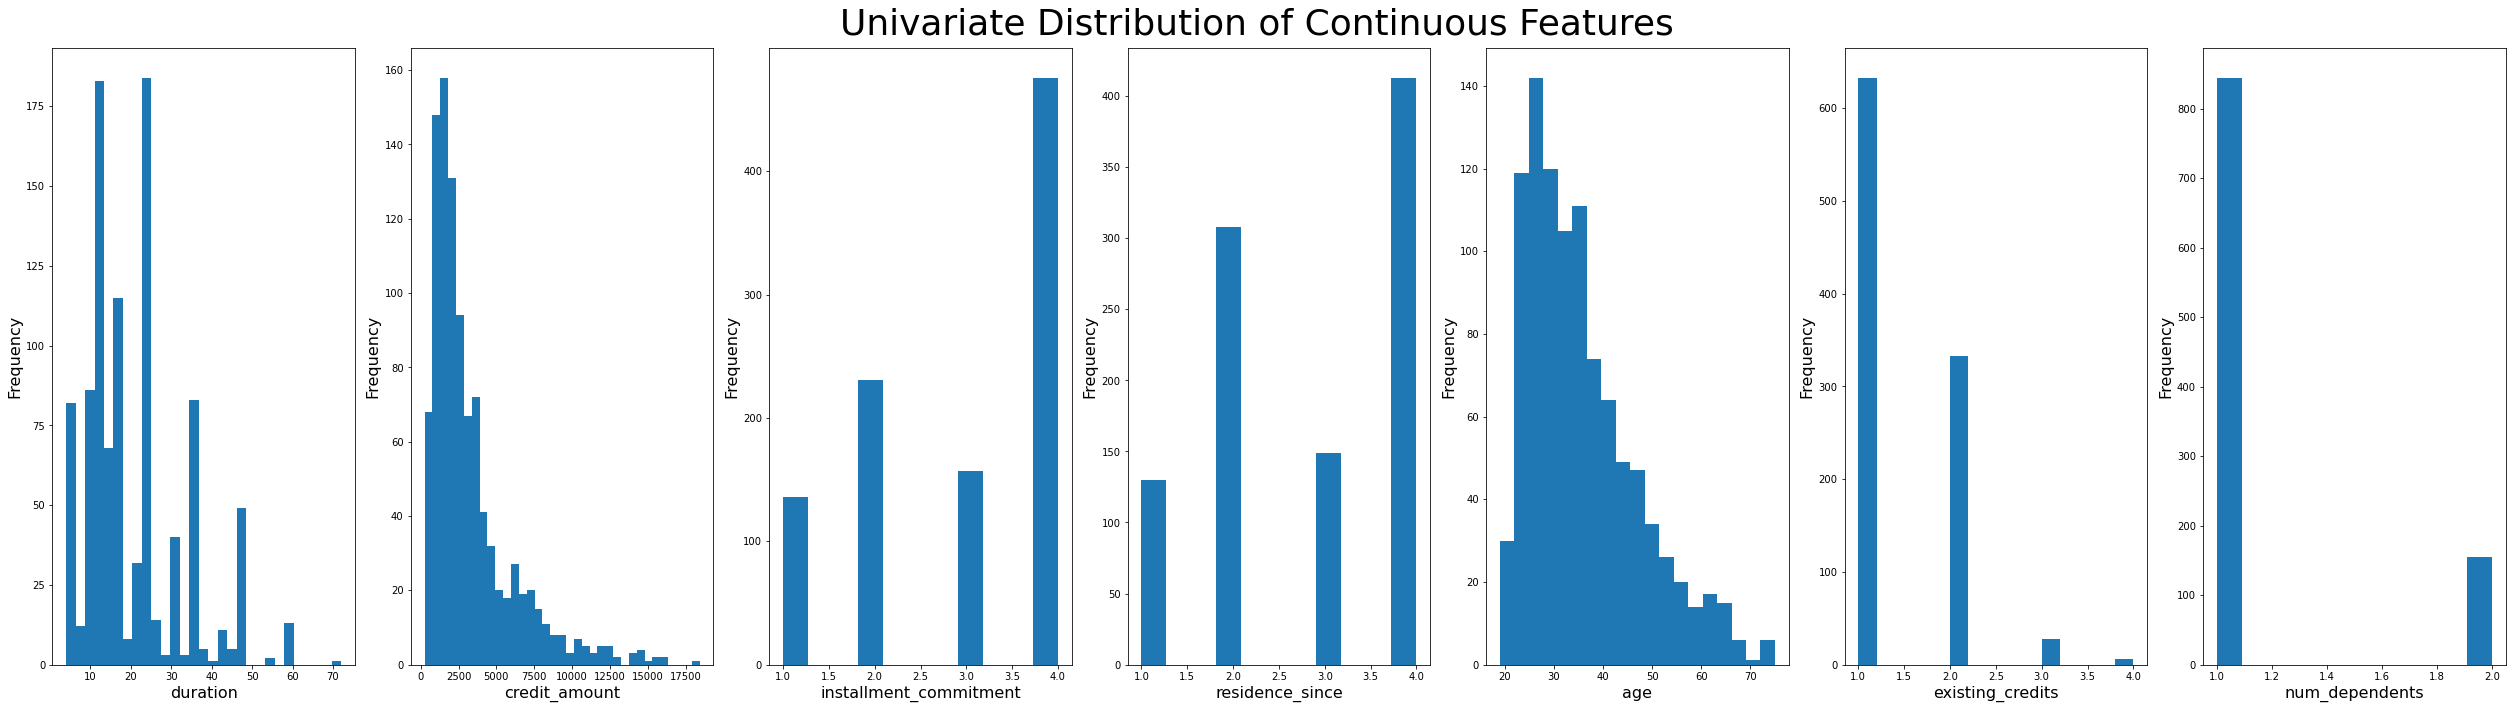

In [12]:
# plot continuous features
fig, axes = plt.subplots(1, len(continuous), figsize=(35, 10))

for i in range(len(continuous)):
    axes[i].hist(df[continuous[i]], bins="auto")
    axes[i].set_xlabel(continuous[i], fontsize=16)
    axes[i].set_ylabel("Frequency", fontsize=16)

fig.suptitle("Univariate Distribution of Continuous Features", fontsize=36)
plt.tight_layout()
plt.show()

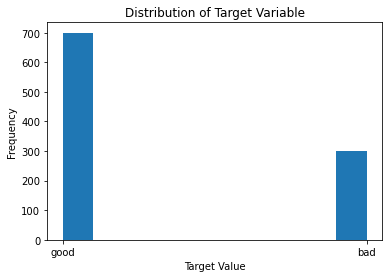

In [13]:
# plot target variable
plt.hist(df['class'])
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.title("Distribution of Target Variable")
plt.show()

### 1.3 Split data into training and test set. Do not use the test set until a final evaluation in 1.5.Preprocess the data (such as treatment of categorical variables) without using a pipeline and evaluate an initial LogisticRegression model with an training/validation split.


In [14]:
X = df[features]
y = df['class']

In [26]:
# create training split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#create validation split
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) # 0.25 x 0.8 = 0.2

print('Training set shape: {}'.format(X_train.shape))
print('Test set shape: {}'.format(X_test.shape))
print('Validation train set shape: {}'.format(X_train_val.shape))
print('Validation test set shape: {}'.format(X_val.shape))

Training set shape: (800, 20)
Test set shape: (200, 20)
Validation train set shape: (640, 20)
Validation test set shape: (160, 20)


In [16]:
## test splits

# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=42) #train set

# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.20, random_state=42) #validation set

# print(X_train_val.shape)
# print(X_train.shape)

Preprocess the data for categorical variables

In [17]:
# OneHotEncoding
ohe = OneHotEncoder(handle_unknown='ignore')

ct = ColumnTransformer(
    [('ohe1', OneHotEncoder(), categorical[:-1])] # remove class from the list
    ,remainder='passthrough')

ct.fit(X_train_val)

X_train_preprocessed = ct.transform(X_train_val)
X_val_preprocessed = ct.transform(X_val)

In [18]:
lr = LogisticRegression()

lr.fit(X_train_preprocessed, y_train_val)

LogisticRegression()

In [19]:
lr_score = lr.score(X_val_preprocessed, y_val)
print('Logistic Regression validation score: {}'.format(lr_score))

Logistic Regression validation score: 0.7375


### 1.4 Use ColumnTransformer and pipeline to encode categorical variables (your choice of OneHotEncoder or another one from the categorical_encoder package, or both). Evaluate Logistic Regression, linear support vector machines and nearest neighbors using cross-validation. How different are the results? How does scaling the continuous features with StandardScaler influence the results?


### Compare Logistic Regression, Linear Support Vector Machine & K Nearest Neighbours using Cross-Validation

In [20]:
model_names = ["LogisticRegression", "LinearSVC", "KNeighboursClassifier"]
model_list = [ LogisticRegression(), LinearSVC(), KNeighborsClassifier()]

In [21]:
# use column transformer and pipeline

preprocess = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), categorical[:-1]), remainder="passthrough")

scores = []
for i in range(len(model_list)):
    score = cross_val_score(make_pipeline(preprocess, model_list[i]), X_train, y_train, cv=5)
    scores.append(np.mean(score))
    
for i in range(len(model_names)):
    print(model_names[i] + ' validation score: ' + str(scores[i]))

LogisticRegression validation score: 0.7375
LinearSVC validation score: 0.58375
KNeighboursClassifier validation score: 0.6537499999999999


In [22]:
# include standard scaler

preprocess = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), categorical[:-1])
                                     ,(StandardScaler(), continuous))

scores = []
for i in range(len(model_list)):
    score = cross_val_score(make_pipeline(preprocess, model_list[i]), X_train, y_train, cv=5)
    scores.append(np.mean(score))
    
for i in range(len(model_names)):
    print(model_names[i] + ' validation score: ' + str(scores[i]))

LogisticRegression validation score: 0.745
LinearSVC validation score: 0.74375
KNeighboursClassifier validation score: 0.7324999999999999


We can see that after scaling, there is a large increase in validation score for LinearSVC and KNN. KNN in particular relies on distances between data points in order to make accurate predictions.

### 1.5 Tune the parameters using GridSearchCV. Do the results improve? Evaluate only the be model on the test set. Visualize the performance as function of the parameters for all three models.


In [30]:
# tune parameters using GridSearchCV

preprocess = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), categorical[:-1])
                                     ,(StandardScaler(), continuous))

pipe = Pipeline([('preprocess', preprocess),
                 ('classfier', LogisticRegression())])

param_grid = [{'classfier': [LogisticRegression(random_state=42)],
               'classfier__C': np.logspace(-3, 2, 10)},
              {'classfier': [LinearSVC(random_state=42)],
               'classfier__C': np.logspace(-3, 2, 10)},
              {'classfier': [KNeighborsClassifier()],
               'classfier__n_neighbors': range(1,15,2)}
             ]
grid = GridSearchCV(pipe, param_grid)
grid.fit(X_train, y_train)
best_score = grid.score(X_test, y_test)

print("The best score:" + str(best_score))
print("The best method along with its parameter values is: " + str(grid.best_params_))

The best score:0.8
The best method along with its parameter values is: {'classfier': LinearSVC(C=0.046415888336127795, random_state=42), 'classfier__C': 0.046415888336127795}


In [32]:
plots = pd.DataFrame(grid.cv_results_)
plots["LR"]= [isinstance(plots["param_classfier"][i],LogisticRegression) for i in range(plots.shape[0])]
plots["SVM"] = [isinstance(plots["param_classfier"][i],LinearSVC) for i in range(plots.shape[0])]
plots["KNN"] = [isinstance(plots["param_classfier"][i],KNeighborsClassifier) for i in range(plots.shape[0])]

In [38]:
# change cross validation strategy to kfold with shuffling

preprocess = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), categorical[:-1])
                                     ,(StandardScaler(), continuous))

pipe = Pipeline([('preprocess', preprocess),
                 ('classfier', LogisticRegression())])

param_grid = [{'classfier': [LogisticRegression(random_state=42)],
               'classfier__C': np.logspace(-3, 2, 10)},
              {'classfier': [LinearSVC(random_state=42)],
               'classfier__C': np.logspace(-3, 2, 10)},
              {'classfier': [KNeighborsClassifier()],
               'classfier__n_neighbors': range(1,15,2)}
             ]
grid = GridSearchCV(pipe, param_grid, cv = KFold(shuffle=True, random_state=42))
grid.fit(X_train, y_train)
best_score = grid.score(X_test, y_test)

print("The best score:" + str(best_score))
print("The best method along with its parameter values is: " + str(grid.best_params_))

The best score:0.795
The best method along with its parameter values is: {'classfier': LogisticRegression(C=0.1668100537200059, random_state=42), 'classfier__C': 0.1668100537200059}


### 1.6 Change the cross-validation strategy from ‘stratified k-fold’ to ‘kfold’ with shuffling. Do the parameters that are found change? Do they change if you change the random seed of the shuffling? Or if you change the random state of the split into training and test data?

In [40]:
# change cross validation strategy to kfold with shuffling
# change random state to 100

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=83)

preprocess = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), categorical[:-1])
                                     ,(StandardScaler(), continuous))

pipe = Pipeline([('preprocess', preprocess),
                 ('classfier', LogisticRegression())])

param_grid = [{'classfier': [LogisticRegression(random_state=42)],
               'classfier__C': np.logspace(-3, 2, 10)},
              {'classfier': [LinearSVC(random_state=42)],
               'classfier__C': np.logspace(-3, 2, 10)},
              {'classfier': [KNeighborsClassifier()],
               'classfier__n_neighbors': range(1,15,2)}
             ]
grid = GridSearchCV(pipe, param_grid, cv = KFold(shuffle=True, random_state=42))
grid.fit(X_train, y_train)
best_score = grid.score(X_test, y_test)

print("The best score:" + str(best_score))
print("The best method along with its parameter values is: " + str(grid.best_params_))

The best score:0.73
The best method along with its parameter values is: {'classfier': LogisticRegression(C=0.1668100537200059, random_state=42), 'classfier__C': 0.1668100537200059}


Changing the random state at the train test split level and KFold level affect the best score. In this case it is lower

In [42]:
preprocess = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), categorical[:-1])
                                     ,(StandardScaler(), continuous))

pipe1 = Pipeline([('preprocess', preprocess),
                 ('classifier', LogisticRegression(random_state=42))])

param_grid = [{'classifier__C': np.logspace(-3, 2, 10)}]
grid = GridSearchCV(pipe1, param_grid)
grid.fit(X_train, y_train)
best_score = grid.score(X_test, y_test)

print("The best score:" + str(best_score))
print("The best parameter values for Logistic Regression: " + str(grid.best_params_))

The best score:0.75
The best parameter values for Logistic Regression: {'classifier__C': 0.5994842503189409}
